In [1]:
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.layers import *
import pandas as pd
import numpy as np
from position import Position
import matplotlib.pyplot as plt
%matplotlib inline
import imp
# imp.reload(cnnfeat)
from multiprocessing import Queue
from multiprocessing import Manager, Process, Pool
import os
from time import time
import pickle
import bcolz
from tqdm import tqdm 
from cnnfeat import get_feats
from cycliclr import CyclicLR
from math import ceil

Using TensorFlow backend.


Initializing Magics


In [2]:
def batch_generator_df_bcolz(dframe, bcolz_arr, batch_size, shuffle=True, yielder=lambda x: x):
    assert(batch_size % bcolz_arr.chunklen == 0)
    chunks_per_batch = batch_size // bcolz_arr.chunklen
    init_bounds = bcolz_arr.partitions
    if bcolz_arr.leftover_elements > 0:
        init_bounds.append((init_bounds[-1][1], len(bcolz_arr)))
    while True:
        bounds = np.random.permutation(init_bounds) if shuffle else init_bounds
        feats_chunks, scores_chunks = [], []
        def return_batch():
            feats = np.concatenate(feats_chunks, axis=0)
            scores = np.concatenate(scores_chunks, axis=0)
            feats_chunks.clear()
            scores_chunks.clear()
            return yielder((feats, scores))
        chunks = 0
        for start, stop in bounds:
            feats_chunks.append(bcolz_arr[start:stop])
            scores_chunks.append(np.array(dframe[start:stop].score, dtype='float32'))
            chunks += 1
            if chunks % chunks_per_batch == 0:
                yield return_batch()
        if len(feats_chunks) > 0:
            yield return_batch()

In [3]:
from bcolz_array_iterator import BcolzArrayIterator

def batch_generator_bcolz(data, batch_size, shuffle=True):
    batch_generator_bcolz = BcolzArrayIterator(data, batch_size=batch_size, shuffle=shuffle)
    while True:
        feats = next(batch_generator_bcolz)
        yield feats, feats

In [4]:
def batch_generator_df(data, batch_size, shuffle=True):
    while True:
        data_ = data.sample(frac=1) if shuffle else data
        for iteration, batch in data_.groupby(np.arange(len(data)) // batch_size):
            fens = [f.strip() for f in batch.fen.tolist()]
            feats = np.stack([get_feats(Position.from_fen(fen)) for fen in fens])
            yield feats, feats

In [5]:
def conv_block(x, filters, kernel_size=(2,2), bottleneck=False, **kwargs):
    if bottleneck:
        x = Convolution2D(filters * 2, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False)(x)
    x = Convolution2D(filters, kernel_size, strides=(1,1), padding='same', use_bias=False)(x)
#                      kernel_regularizer=l2(1e-6))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    return x

def dense_block(x, filters, nb_layers):
    layers = [x]
    for i in range(nb_layers):
        x = conv_block(x, filters, bottleneck=(i>=1))
        layers.append(x)
        x = Concatenate(axis=-1)(layers)
    return x

def transition(input_tensor, out_filters):
    x = conv_block(input_tensor, out_filters, kernel_size=(1,1))
    x = AveragePooling2D((2,2), strides=(2,2))(x)
    return x

def cnn_model():
    net_input = Input((8,8,14))
    #x = conv_block(net_input, 14, kernel_size=(3,3))
    x = Dense(32)(net_input)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = dense_block(x, 4, 8)
#     x = transition(x, 14)
#     x = dense_block(x, 7, 4)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(1)(x)
    net_output = Activation('tanh')(x)
    # 45k params
    return net_input, net_output

In [6]:
inputs, outputs = cnn_model()
model = Model(inputs, outputs)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 14)     0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8, 8, 32)     480         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8, 8, 32)     128         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 8, 8, 32)     0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [11]:
# features = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3_sample.bc')
# features_valid = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3_valid_sample.bc')

features = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3.bc')
features_valid = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3_valid.bc')

sf_scores_all = pd.read_pickle('/ssd/slonik_data/sf_scores_3dep.pkl')
sf_scores = sf_scores_all[:-60000]
sf_scores_valid = sf_scores_all[-60000:]

assert(np.allclose(features_valid[0], get_feats(Position.from_fen(sf_scores_valid.iloc[0].fen))))
assert(np.allclose(features[0], get_feats(Position.from_fen(sf_scores.iloc[0].fen))))

In [43]:
model.compile(keras.optimizers.SGD(), 'mse')

In [40]:
model.compile(keras.optimizers.SGD(lr=.01, momentum=.95, nesterov=True), 'mse')

In [8]:
model.compile('adam', 'mse')

In [58]:
K.get_value(model.optimizer.lr)

0.001

In [11]:
wgts = model.get_weights()

In [74]:
model.set_weights(wgts)

In [15]:
batch_size = 1024
#nvalid = len(features_sf12_valid)

# yielder = lambda f_s: (f_s[0], [f_s[0], f_s[1]]) # (feats, [feats, scores])
train_gen = batch_generator_df_bcolz(sf_scores, features, batch_size)
valid_gen = batch_generator_df_bcolz(sf_scores_valid, features_valid, batch_size, shuffle=False)

train_steps = ceil(len(features) / batch_size)
valid_steps = ceil(len(features_valid) / batch_size)

# lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
checkpoint_path = '../slonik_data/weights_best.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             monitor='val_loss', save_best_only=True, save_weights_only=True, period=1)
# stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')
# clr = CyclicLR(base_lr=1e-6, max_lr=1e-5, step_size=train_steps*5, mode='triangular')
clr_step_size = 5
clr = CyclicLR(base_lr=1e-6, max_lr=1e-3, step_size=train_steps*clr_step_size, mode='exp_range', gamma=0.99999)
# clr = CyclicLR(base_lr=0, max_lr=1e-2, step_size=train_steps*5, mode='triangular')

# callbacks = [clr]
callbacks = [clr, checkpoint]
# callbacks = [checkpoint]
# K.set_value(model.optimizer.lr, 1e-4)
hist = model.fit_generator(train_gen, train_steps, epochs=300, 
                          validation_data=valid_gen, validation_steps=valid_steps, callbacks=callbacks)

# K.set_value(model.optimizer.lr, 1e-5)
# model.fit_generator(train_gen, train_steps, epochs=1, validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/300
231/231 [==============================] - 7s 32ms/step - loss: 0.0391 - val_loss: 0.0606
Epoch 2/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0068 - val_loss: 0.0077
Epoch 3/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 4/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0036 - val_loss: 0.0063
Epoch 5/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 6/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 7/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/300
231/231 [==============================] - 7s 29ms/step - loss: 0.001

231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 9.3412e-04
Epoch 81/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 9.3457e-04
Epoch 82/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 9.9718e-04
Epoch 83/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 84/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 85/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 86/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 87/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 9.4295e-04
Epoch 88/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 9.8401e-04
Epoch 89/300
231/231 [==============================] - 7s 29ms/st

231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 8.8491e-04
Epoch 234/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 235/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 9.4430e-04
Epoch 236/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 237/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 238/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 8.9486e-04
Epoch 239/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 9.0362e-04
Epoch 240/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 8.7119e-04
Epoch 241/300
231/231 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 8.7861e-04
Epoch 242/300
231/231 [==============================]

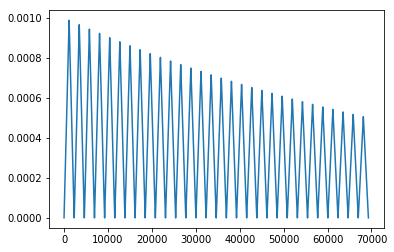

In [16]:
plt.plot(clr.history['iterations'], clr.history['lr'])

In [29]:
model.load_weights('../slonik_data/weights_best.h5')

In [40]:
model.compile(keras.optimizers.SGD(lr=.01, momentum=.95, nesterov=True), 'mse')

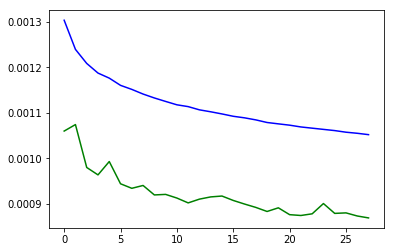

In [22]:
rng = np.s_[clr_step_size*4::clr_step_size*2]
fig = plt.plot(np.arange(len(hist.history['loss'][rng])), hist.history['loss'][rng], 'b'); fig
plt.plot(np.arange(len(hist.history['loss'][rng])), hist.history['val_loss'][rng], 'g')

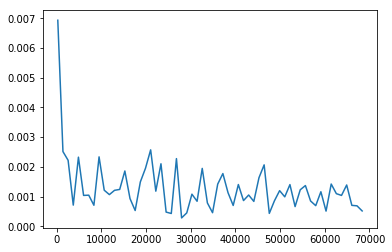

In [25]:
rng = np.s_[train_steps::train_steps*clr_step_size]
plt.plot(clr.history['iterations'][rng], clr.history['loss'][rng])

### evaluate models

In [28]:
batch_size = 1024 * 2
valid_steps = ceil(len(features_valid) / batch_size)
valid_gen = batch_generator_df_bcolz(sf_scores_valid, features_valid, batch_size, shuffle=False)
model.evaluate_generator(valid_gen, steps=valid_steps)
# 0.00096135296067222954

0.00086251940000802276

In [9]:
model.load_weights('/ssd/slonik_data/cnn1_weights.h5')

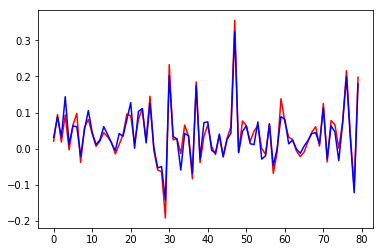

In [12]:
rng = slice(0,80)
fens = sf_scores_valid[rng].fen
scores = sf_scores_valid[rng].score
# np.allclose(features_sf12_valid[rng], np.array([get_feats(Position.from_fen(f)) for f in fens]))
# pprint(list(zip(scores, evaluator.predict(features_sf12_valid[rng]).squeeze())))
x = np.arange(len(scores))
plt.plot(x, scores, 'r')
plt.plot(x, model.predict(features_valid[rng]).squeeze(), 'b')

In [13]:
model.save('/ssd/slonik_data/cnn1_model.h5')